# Demand Forecasting (1–28 Days)

This notebook is a clean, end‑to‑end workflow tailored to **time‑series demand forecasting** with **rolling 4‑fold validation** and **baseline + ML comparison**.

**What this notebook does:**
- Load and validate the dataset (types, missing values, date range)
- Perform EDA on distribution, seasonality, event effects, intermittency, and demand concentration
- Add deeper EDA (store/SKU seasonal indices and clustering of similar series)
- Summarize business insights and rank stores/SKUs by total volume
- Engineer features (calendar, lags, rolling stats)
- Split data using **date‑based 4‑fold time‑series CV** (all store×SKU in train & val)
- Train baselines (naive lag‑7, moving average‑7)
- Train ML models (HistGBR + XGBoost) with hyperparameter tuning
- Evaluate **overall** performance across folds (MAE, RMSE, MAPE, sMAPE, WAPE)
- Add **recursive multi‑step evaluation** (compounding errors like real forecasting)
- Compare models in unified tables and explain metric interpretation
- Run diagnostics (residual distributions, drift, event‑level residuals)
- Break down errors by store and SKU using MAE/MSE/WAPE
- Summarize business value and recommended next steps
- Generate a 28‑day forecast for every store‑SKU

In [53]:
# Imports
import json
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor


In [54]:
# Config
DATA_PATH = Path("demand_forecasting_assignment.csv")

GROUP_COLS = ["store_id", "sku_id"]
TARGET_COL = "sales_quantity"
DATE_COL = "date"
EVENT_COL = "event_type"

LAGS = [1, 7, 14, 28]
ROLL_WINDOWS = [7, 14, 28]


## 1) Load Data
We load the dataset, parse dates, and sort by store/SKU/date to preserve time order.


In [55]:
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(GROUP_COLS + [DATE_COL]).reset_index(drop=True)

df.head()


,date,store_id,sku_id,event_type,sales_quantity
0,2022-01-01,Store_1,sku_000,none,0.0
1,2022-01-02,Store_1,sku_000,none,0.0
2,2022-01-03,Store_1,sku_000,none,0.0
3,2022-01-04,Store_1,sku_000,none,49.0
4,2022-01-05,Store_1,sku_000,none,0.0


In [56]:
# Shape, types, missing values
(df.shape, df.dtypes)


((146000, 5),
 date              datetime64[ns]
 store_id                  object
 sku_id                    object
 event_type                object
 sales_quantity           float64
 dtype: object)

In [57]:
df.isna().sum()


date              0
store_id          0
sku_id            0
event_type        0
sales_quantity    0
dtype: int64

## 2) EDA (Distribution & Time Patterns)
We look at sales distribution, time trends, events, seasonality, and intermittency.


In [58]:
# Summary stats
eda_summary = {
    "date_min": df[DATE_COL].min(),
    "date_max": df[DATE_COL].max(),
    "num_days": df[DATE_COL].nunique(),
    "num_stores": df["store_id"].nunique(),
    "num_skus": df["sku_id"].nunique(),
    "num_series": df[GROUP_COLS].drop_duplicates().shape[0],
    "rows": len(df),
    "zero_rate": float((df[TARGET_COL] == 0).mean()),
}
eda_summary


{'date_min': Timestamp('2022-01-01 00:00:00'),
 'date_max': Timestamp('2023-12-31 00:00:00'),
 'num_days': 730,
 'num_stores': 10,
 'num_skus': 20,
 'num_series': 200,
 'rows': 146000,
 'zero_rate': 0.3156301369863014}

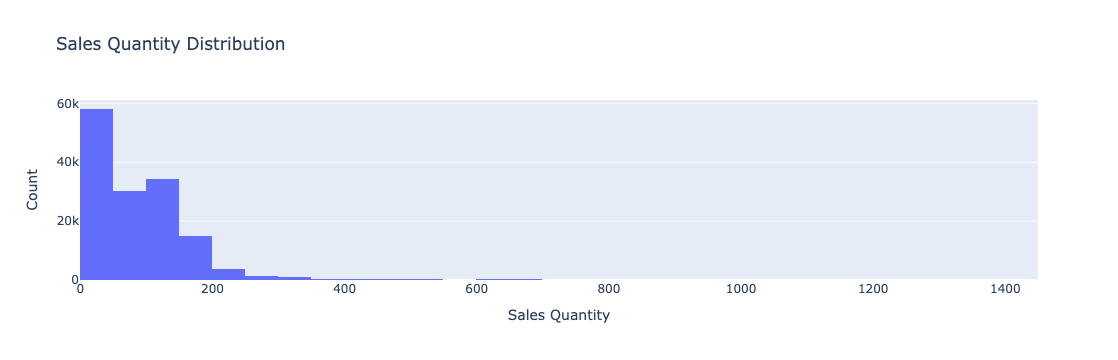

In [59]:
# Sales distribution 
fig = px.histogram(df, x=TARGET_COL, nbins=50, title='Sales Quantity Distribution')
fig.update_layout(xaxis_title='Sales Quantity', yaxis_title='Count')
fig.show()


distribution of daily sales. A heavy right tail indicates occasional high‑demand spikes (often promo‑driven), while a large mass near zero suggests intermittent demand for some store‑SKU pairs.

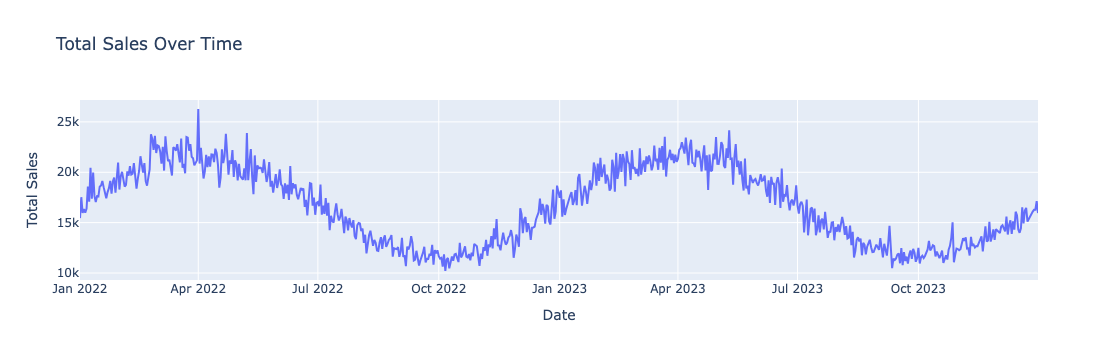

In [60]:
# Total sales over time 
agg = df.groupby(DATE_COL)[TARGET_COL].sum().reset_index()
fig = px.line(agg, x=DATE_COL, y=TARGET_COL, title='Total Sales Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Total Sales')
fig.show()


This line reveals overall trend and seasonality. Look for sustained upward/downward drift and recurring peaks that align with known events or seasonal cycles.

In [61]:
# Event uplift
_event = df.groupby(EVENT_COL)[TARGET_COL].agg(['mean','median','count']).sort_values('mean', ascending=False)
none_mean = _event.loc['none','mean'] if 'none' in _event.index else df[TARGET_COL].mean()
_event['uplift_vs_none'] = _event['mean'] / none_mean
_event


,mean,median,count,uplift_vs_none
event_type,,,,
mega_sale,327.657392,369.0,2983,4.488136
seasonal_sale,159.982729,176.0,5790,2.191387
flash_sale,102.797596,115.0,8735,1.408086
none,73.005222,81.0,128492,1.000000


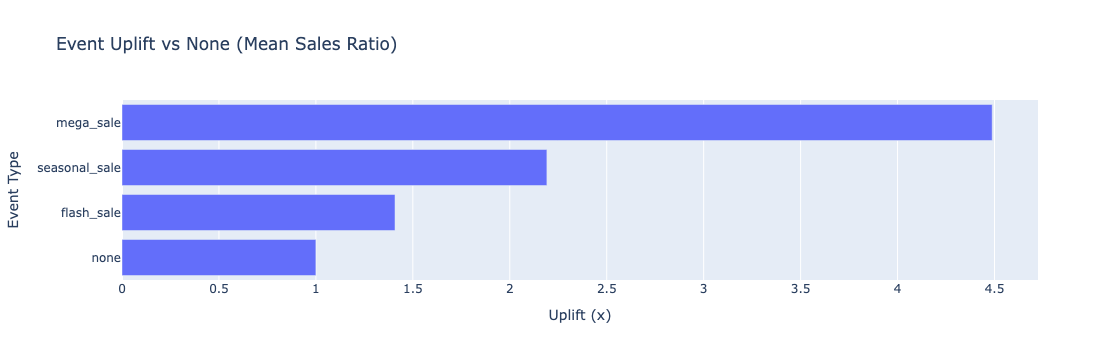

In [62]:
# Event uplift chart 
_event_plot = _event['uplift_vs_none'].sort_values().reset_index()
fig = px.bar(_event_plot, x='uplift_vs_none', y=EVENT_COL, orientation='h', title='Event Uplift vs None (Mean Sales Ratio)')
fig.update_layout(xaxis_title='Uplift (x)', yaxis_title='Event Type')
fig.show()


Bars above 1.0 indicate events that lift demand relative to normal days. The larger the uplift, the more critical it is to model that event type explicitly.

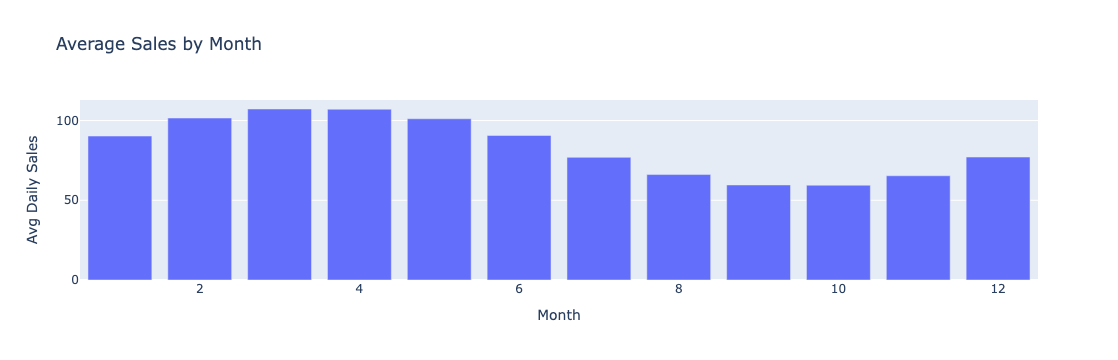

In [63]:
# Monthly seasonality 
month_mean = df.groupby(df[DATE_COL].dt.month)[TARGET_COL].mean().reset_index()
month_mean.columns = ['month', 'avg_sales']
fig = px.bar(month_mean, x='month', y='avg_sales', title='Average Sales by Month')
fig.update_layout(xaxis_title='Month', yaxis_title='Avg Daily Sales')
fig.show()


Highlights which months are naturally stronger or weaker. Use this to plan inventory and staffing and to create month‑level seasonal features.

In [64]:
# Day-of-week seasonality 
weekday_mean = df.groupby(df[DATE_COL].dt.dayofweek)[TARGET_COL].mean().reset_index()
weekday_mean.columns = ['dow', 'avg_sales']
fig = px.bar(weekday_mean, x='dow', y='avg_sales', title='Average Sales by Day of Week')
fig.update_layout(xaxis_title='Day of Week (0=Mon)', yaxis_title='Avg Daily Sales')
fig.show()


Shows weekday patterns. If differences are small, weekday effects are minor and may be less important than monthly or event effects.

In [65]:
# Demand concentration (SKU Pareto) 
sku_total = df.groupby('sku_id')[TARGET_COL].sum().sort_values(ascending=False)
sku_share = sku_total / sku_total.sum()
sku_cum = sku_share.cumsum()
pareto_df = pd.DataFrame({'sku_rank': range(1, len(sku_cum)+1), 'cum_share': sku_cum.values})

fig = px.line(pareto_df, x='sku_rank', y='cum_share', title='SKU Cumulative Sales Share (Pareto)')
fig.add_hline(y=0.8, line_dash='dash', line_color='red')
fig.update_layout(xaxis_title='SKU Rank', yaxis_title='Cumulative Share')
fig.show()

pareto_80 = int((sku_cum <= 0.8).sum())
pareto_80, len(sku_total)


(14, 20)

The steepness of the curve shows concentration. If 80% of volume is reached by a small number of SKUs, prioritize modeling accuracy for those SKUs first.

In [66]:
# Intermittency by series
series_stats = df.groupby(GROUP_COLS)[TARGET_COL].agg(
    mean='mean',
    std='std',
    zero_rate=lambda s: (s==0).mean(),
    total='sum'
).reset_index()

series_stats['zero_rate'].describe(percentiles=[0.1,0.5,0.9])


count    200.000000
mean       0.315630
std        0.351481
min        0.006849
10%        0.019041
50%        0.097260
90%        0.816438
max        0.850685
Name: zero_rate, dtype: float64

In [67]:
series_stats

,store_id,sku_id,mean,std,zero_rate,total
0,Store_1,sku_000,14.720548,27.999828,0.750685,10746.0
1,Store_1,sku_001,112.020548,101.606403,0.084932,81775.0
2,Store_1,sku_002,127.780822,59.489679,0.027397,93280.0
3,Store_1,sku_003,110.580822,102.769040,0.112329,80724.0
4,Store_1,sku_004,131.680822,64.129848,0.020548,96127.0
...,...,...,...,...,...,...
195,Store_9,sku_015,134.356164,83.241442,0.031507,98080.0
196,Store_9,sku_016,112.116438,94.248447,0.069863,81845.0
197,Store_9,sku_017,136.284932,76.480546,0.010959,99488.0
198,Store_9,sku_018,131.189041,61.759056,0.021918,95768.0


## 2b) Deeper EDA: Store/SKU, Seasonal Index, and Series Clusters
We dig deeper into store/SKU behavior, compute seasonal indices, and cluster series with similar demand patterns.


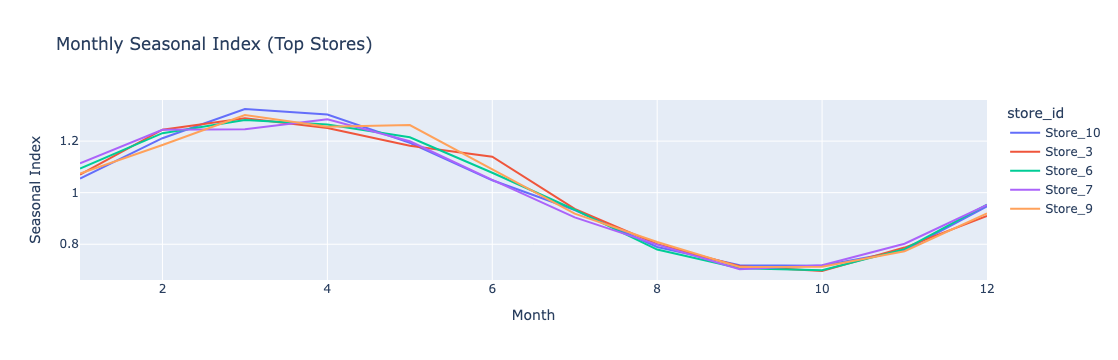

In [68]:
# Store-level seasonality index (monthly)
store_month = df.groupby(['store_id', df[DATE_COL].dt.month])[TARGET_COL].mean().reset_index()
store_month.columns = ['store_id', 'month', 'avg_sales']

# Normalize by each store's overall mean to get a seasonal index
store_mean = df.groupby('store_id')[TARGET_COL].mean().reset_index().rename(columns={TARGET_COL: 'store_mean'})
store_seasonal = store_month.merge(store_mean, on='store_id')
store_seasonal['seasonal_index'] = store_seasonal['avg_sales'] / store_seasonal['store_mean']

# Plot a few top-volume stores
top_stores = df.groupby('store_id')[TARGET_COL].sum().sort_values(ascending=False).head(5).index
plot_df = store_seasonal[store_seasonal['store_id'].isin(top_stores)]
fig = px.line(plot_df, x='month', y='seasonal_index', color='store_id',
              title='Monthly Seasonal Index (Top Stores)')
fig.update_layout(xaxis_title='Month', yaxis_title='Seasonal Index')
fig.show()


**Interpretation:** A seasonal index >1 means above‑average demand for that store in that month; <1 means below‑average. Use this to time store‑specific inventory plans.

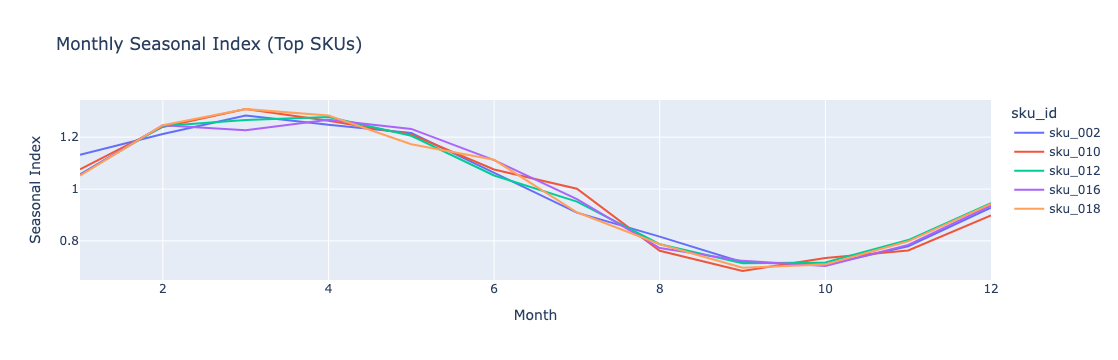

In [69]:
# SKU-level seasonality index (monthly)
sku_month = df.groupby(['sku_id', df[DATE_COL].dt.month])[TARGET_COL].mean().reset_index()
sku_month.columns = ['sku_id', 'month', 'avg_sales']

sku_mean = df.groupby('sku_id')[TARGET_COL].mean().reset_index().rename(columns={TARGET_COL: 'sku_mean'})
sku_seasonal = sku_month.merge(sku_mean, on='sku_id')
sku_seasonal['seasonal_index'] = sku_seasonal['avg_sales'] / sku_seasonal['sku_mean']

# Plot a few top-volume SKUs
top_skus = df.groupby('sku_id')[TARGET_COL].sum().sort_values(ascending=False).head(5).index
plot_df = sku_seasonal[sku_seasonal['sku_id'].isin(top_skus)]
fig = px.line(plot_df, x='month', y='seasonal_index', color='sku_id',
              title='Monthly Seasonal Index (Top SKUs)')
fig.update_layout(xaxis_title='Month', yaxis_title='Seasonal Index')
fig.show()


**Interpretation:** SKU seasonal indices reveal which products are seasonal versus steady sellers. This is useful for promotional timing and pre‑buying inventory.

In [70]:
# Store/SKU performance summary
store_perf = df.groupby('store_id')[TARGET_COL].agg(['sum','mean','std']).reset_index()
sku_perf = df.groupby('sku_id')[TARGET_COL].agg(['sum','mean','std']).reset_index()

store_perf.head()


,store_id,sum,mean,std
0,Store_1,1085450.0,74.345890,85.560354
1,Store_10,1303722.0,89.296027,90.624799
2,Store_2,1122156.0,76.860000,88.752367
3,Store_3,1373537.0,94.077877,95.256200
4,Store_4,1124625.0,77.029110,91.215574


**Interpretation:** Store and SKU summaries highlight volume concentration and volatility differences. High mean + high std implies demand volatility and higher risk.

In [71]:
# Cluster series by demand characteristics
from sklearn.cluster import KMeans

# Build per-series features
series = df.groupby(GROUP_COLS).apply(
    lambda g: pd.Series({
        'mean': g[TARGET_COL].mean(),
        'std': g[TARGET_COL].std(),
        'zero_rate': (g[TARGET_COL]==0).mean(),
        'trend': np.corrcoef(np.arange(len(g)), g[TARGET_COL].values)[0,1],
    })
).reset_index()

series['cv'] = series['std'] / series['mean'].replace(0, np.nan)
series = series.replace([np.inf, -np.inf], np.nan).fillna(0)

# KMeans clustering
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
series['cluster'] = km.fit_predict(series[['mean','std','zero_rate','trend','cv']])

# Cluster summary
cluster_summary = series.groupby('cluster')[['mean','std','zero_rate','trend','cv']].mean().reset_index()
cluster_summary


/var/folders/jv/25ssb6jn5s590bmt80k0ngdr0000gn/T/ipykernel_18684/3993626095.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,cluster,mean,std,zero_rate,trend,cv
0,0,134.168102,74.188651,0.020665,-0.144429,0.552174
1,1,12.031868,27.427028,0.780384,-0.027965,2.361096
2,2,110.860675,97.901946,0.094686,-0.101843,0.882382


**Interpretation:** Clusters reveal groups such as stable high‑volume series, volatile promo‑driven series, and intermittent low‑volume series. This supports segmented modeling strategies.

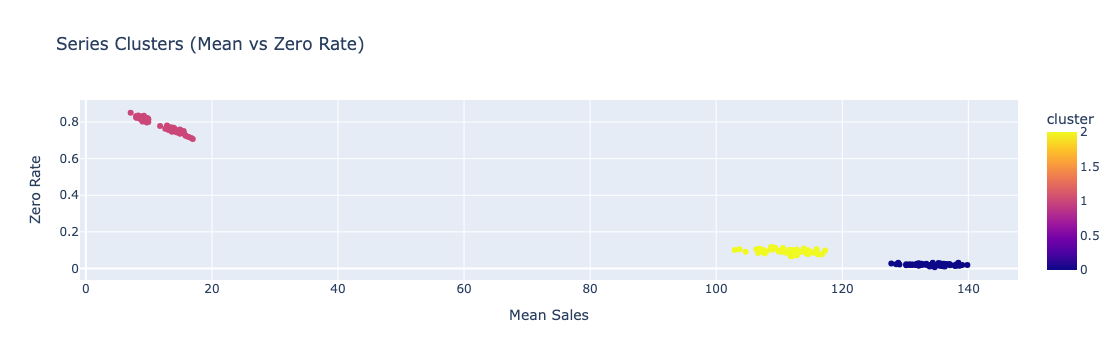

In [72]:
# Plot clusters (mean vs zero_rate)
fig = px.scatter(series, x='mean', y='zero_rate', color='cluster',
                 hover_data=['store_id','sku_id'],
                 title='Series Clusters (Mean vs Zero Rate)')
fig.update_layout(xaxis_title='Mean Sales', yaxis_title='Zero Rate')
fig.show()


**Interpretation:** Points to the upper‑right (high mean, high zero rate) often represent bursty demand. Lower‑left clusters are stable low‑volume series.

## 3) Business Insights (Summary)
- **Promotions dominate demand:** event types create large uplift; these are the highest‑impact features to model.
- **Seasonality is meaningful:** monthly seasonal indices show consistent peaks and troughs across stores/SKUs.
- **Volume concentration:** a small subset of SKUs and stores drives most sales—prioritize accuracy here.
- **Intermittency is real:** many series have high zero rates, so use WAPE/sMAPE and consider segmented models.
- **Store/SKU profiles differ:** some are stable (low variance), others are volatile or bursty—use clustering to segment.
- **Clusters suggest strategy:** stable high‑volume series can use standard ML, while bursty/intermittent groups may need special handling.


## 4) Store & SKU Rankings
These rankings show where accuracy improvements have the highest business impact.


In [73]:
# Store ranking table
store_rank = df.groupby('store_id')[TARGET_COL].sum().sort_values(ascending=False)
store_rank = store_rank.reset_index().rename(columns={TARGET_COL: 'total_sales'})
store_rank


,store_id,total_sales
0,Store_9,1502606.0
1,Store_7,1411742.0
2,Store_3,1373537.0
3,Store_10,1303722.0
4,Store_6,1227456.0
5,Store_4,1124625.0
6,Store_2,1122156.0
7,Store_8,1116199.0
8,Store_1,1085450.0
9,Store_5,914733.0


In [74]:
# SKU ranking table
sku_rank = df.groupby('sku_id')[TARGET_COL].sum().sort_values(ascending=False)
sku_rank = sku_rank.reset_index().rename(columns={TARGET_COL: 'total_sales'})
sku_rank


,sku_id,total_sales
0,sku_002,926634.0
1,sku_018,819206.0
2,sku_012,748939.0
3,sku_010,736171.0
4,sku_016,711100.0
5,sku_009,677023.0
6,sku_011,672764.0
7,sku_008,657449.0
8,sku_000,628231.0
9,sku_004,589727.0


## 5) Feature Engineering
We add calendar features, lags, and rolling statistics to capture seasonality and momentum.


In [75]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['dow'] = df[DATE_COL].dt.dayofweek
    df['month'] = df[DATE_COL].dt.month
    df['weekofyear'] = df[DATE_COL].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    return df


def add_lag_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby(GROUP_COLS)[TARGET_COL]

    for lag in LAGS:
        df[f'lag_{lag}'] = g.shift(lag)

    for window in ROLL_WINDOWS:
        df[f'roll_mean_{window}'] = g.transform(lambda s: s.shift(1).rolling(window).mean())
        df[f'roll_std_{window}'] = g.transform(lambda s: s.shift(1).rolling(window).std())

    return df


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = add_time_features(df)
    df = add_lag_rolling_features(df)
    return df


In [76]:
df_feat = build_features(df)
df_feat.head()


,date,store_id,sku_id,event_type,sales_quantity,dow,month,weekofyear,is_weekend,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_28,roll_std_28
0,2022-01-01,Store_1,sku_000,none,0.0,5,1,52,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,Store_1,sku_000,none,0.0,6,1,52,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-03,Store_1,sku_000,none,0.0,0,1,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-04,Store_1,sku_000,none,49.0,1,1,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-05,Store_1,sku_000,none,0.0,2,1,1,0,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
def prepare_supervised(df: pd.DataFrame):
    df = df.dropna().copy()
    feature_cols = [
        'store_id','sku_id',EVENT_COL,
        'dow','month','weekofyear','is_weekend'
    ] + [f'lag_{l}' for l in LAGS] + [
        f'roll_mean_{w}' for w in ROLL_WINDOWS
    ] + [
        f'roll_std_{w}' for w in ROLL_WINDOWS
    ]

    X = df[feature_cols]
    y = df[TARGET_COL]
    return X, y, feature_cols


## 6) Train/Validation Split (Rolling 4‑Fold, All Store×SKU in Train & Val)
We split **by date** (not by row) so every fold includes **all store‑SKU pairs** in both train and validation. This avoids leakage and ensures consistent coverage across series.


In [78]:
from sklearn.model_selection import TimeSeriesSplit

# Build features first
ordered = df_feat.sort_values(GROUP_COLS + [DATE_COL]).copy()

# Use unique dates for time splits to keep all store×SKU in each fold
unique_dates = np.array(sorted(ordered[DATE_COL].unique()))

tscv = TimeSeriesSplit(n_splits=4)

# Each fold is a list of (train_dates, val_dates)
folds = []
for train_idx, val_idx in tscv.split(unique_dates):
    train_dates = set(unique_dates[train_idx])
    val_dates = set(unique_dates[val_idx])
    folds.append((train_dates, val_dates))

print('Number of folds:', len(folds))

# Use last fold for diagnostics later
train_dates, val_dates = folds[-1]

# Build train/val sets using date masks (all store×SKU appear in both)
train_df = ordered[ordered[DATE_COL].isin(train_dates)].copy()
val_df = ordered[ordered[DATE_COL].isin(val_dates)].copy()

X_train, y_train, _ = prepare_supervised(train_df)
X_val, y_val, _ = prepare_supervised(val_df)

X_train.shape, X_val.shape


Number of folds: 4


((111200, 17), (29200, 17))

In [79]:
# Sanity check: ensure every store×SKU is present in both train and val for each fold
all_pairs = set(tuple(x) for x in df[GROUP_COLS].drop_duplicates().values)

missing_report = []
for k, (train_dates, val_dates) in enumerate(folds, start=1):
    train_pairs = set(tuple(x) for x in df_feat[df_feat[DATE_COL].isin(train_dates)][GROUP_COLS].drop_duplicates().values)
    val_pairs = set(tuple(x) for x in df_feat[df_feat[DATE_COL].isin(val_dates)][GROUP_COLS].drop_duplicates().values)

    missing_train = all_pairs - train_pairs
    missing_val = all_pairs - val_pairs

    missing_report.append({
        'fold': k,
        'missing_in_train': len(missing_train),
        'missing_in_val': len(missing_val),
    })

pd.DataFrame(missing_report)


,fold,missing_in_train,missing_in_val
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0


## 7) Models
We compare:
- Baselines: naive lag‑7, moving average (7)
- HistGradientBoostingRegressor (main)
- XGBoost (optional strong baseline)



**Why this setup:**
- Rolling time splits avoid leakage and simulate real forecasting.
- Baselines establish a clear performance floor.
- ML models capture nonlinear promo effects and cross‑series patterns.


**Why a global ML model (lags/rolling features) instead of decomposition:**
- We have many parallel series (200 store×SKU), so per‑series decomposition is heavy and inconsistent.
- Promotions create large, irregular spikes; ML can directly model `event_type` effects, while decomposition assumes stable seasonality.
- Many series are intermittent with zeros, which reduces decomposition reliability.
- The 1–28 day horizon benefits most from recent momentum captured by lags/rolling stats.
- ML optimizes business metrics (WAPE/MAE) at scale with fewer moving parts.

**When decomposition would make sense:** fewer series, longer stable histories, or a need for explicit trend/seasonality components.


In [80]:
def build_preprocessor():
    categorical = ['store_id','sku_id',EVENT_COL]
    numeric = ['dow','month','weekofyear','is_weekend'] + [
        f'lag_{l}' for l in LAGS
    ] + [
        f'roll_mean_{w}' for w in ROLL_WINDOWS
    ] + [
        f'roll_std_{w}' for w in ROLL_WINDOWS
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('num', 'passthrough', numeric),
        ]
    )
    return preprocessor

preprocessor = build_preprocessor()


In [81]:
# HistGBR pipeline
histgbr_model = HistGradientBoostingRegressor(
    loss='absolute_error',
    random_state=42,
)

histgbr_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', histgbr_model)
])


In [82]:
# HistGBR hyperparameter tuning
histgbr_param_dist = {
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__max_depth': [3, 5, None],
    'model__max_iter': [200, 400, 600],
    'model__l2_regularization': [0.0, 0.1, 1.0],
}

histgbr_search = RandomizedSearchCV(
    histgbr_pipe,
    param_distributions=histgbr_param_dist,
    n_iter=8,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    random_state=42,
    n_jobs=-1,
)

histgbr_search.fit(X_train, y_train)

histgbr_best_model = histgbr_search.best_estimator_
histgbr_best_params = histgbr_search.best_params_

histgbr_best_params


{'model__max_iter': 400,
 'model__max_depth': 5,
 'model__learning_rate': 0.03,
 'model__l2_regularization': 0.1}

In [83]:
# XGBoost (optional)
try:
    from xgboost import XGBRegressor

    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )

    xgb_pipe = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', xgb_model)
    ])

    xgb_param_dist = {
        'model__n_estimators': [300, 500, 800],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.03, 0.05, 0.1],
        'model__subsample': [0.7, 0.85, 1.0],
        'model__colsample_bytree': [0.7, 0.85, 1.0],
        'model__min_child_weight': [1, 5, 10],
        'model__reg_alpha': [0.0, 0.1, 1.0],
        'model__reg_lambda': [1.0, 5.0, 10.0],
    }

    xgb_search = RandomizedSearchCV(
        xgb_pipe,
        param_distributions=xgb_param_dist,
        n_iter=12,
        scoring='neg_mean_absolute_error',
        cv=TimeSeriesSplit(n_splits=3),
        random_state=42,
        n_jobs=-1,
    )

    xgb_search.fit(X_train, y_train)

    xgb_best_model = xgb_search.best_estimator_
    xgb_best_params = xgb_search.best_params_

    xgb_best_params

except Exception as e:
    print("XGBoost not available:", e)


## 8) Evaluation
We use MAE, RMSE, MAPE, sMAPE, and WAPE for scale‑aware assessment.


In [84]:
def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)

    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))
    smape = np.mean(
        2.0 * np.abs(y_pred - y_true) / np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    )
    wape = np.sum(np.abs(y_true - y_pred)) / np.maximum(np.sum(np.abs(y_true)), eps)

    return {
        'MAE': float(mae),
        'RMSE': float(rmse),
        'MAPE': float(mape),
        'sMAPE': float(smape),
        'WAPE': float(wape),
    }


In [85]:
# Baselines: naive lag-7 and moving average (4-fold CV overall)
base = df_feat.sort_values(GROUP_COLS + [DATE_COL]).copy()
base['naive_lag7'] = base.groupby(GROUP_COLS)[TARGET_COL].shift(7)
base['ma7'] = base.groupby(GROUP_COLS)[TARGET_COL].transform(lambda s: s.shift(1).rolling(7).mean())

baseline_scores = []
ma7_scores = []

for train_dates, val_dates in folds:
    val_base = base[base[DATE_COL].isin(val_dates)].dropna(subset=['naive_lag7'])
    val_ma = base[base[DATE_COL].isin(val_dates)].dropna(subset=['ma7'])

    baseline_scores.append(evaluate(val_base[TARGET_COL].values, val_base['naive_lag7'].values))
    ma7_scores.append(evaluate(val_ma[TARGET_COL].values, val_ma['ma7'].values))

baseline_metrics = pd.DataFrame(baseline_scores).mean().to_dict()
ma7_metrics = pd.DataFrame(ma7_scores).mean().to_dict()

baseline_metrics, ma7_metrics


({'MAE': 45.242054794520556,
  'RMSE': 8264.187945205478,
  'MAPE': 705124144.3984226,
  'sMAPE': 0.6045220222178339,
  'WAPE': 0.5733861735228453},
 {'MAE': 36.696854207436395,
  'RMSE': 4676.145779983226,
  'MAPE': 698370964.2665995,
  'sMAPE': 0.8341695448846645,
  'WAPE': 0.46478345567451707})

In [86]:
# HistGBR evaluation (4-fold CV overall)
histgbr_scores = []

for train_dates, val_dates in folds:
    train_df = df_feat[df_feat[DATE_COL].isin(train_dates)]
    val_df = df_feat[df_feat[DATE_COL].isin(val_dates)]

    X_tr, y_tr, _ = prepare_supervised(train_df)
    X_va, y_va, _ = prepare_supervised(val_df)

    histgbr_best_model.fit(X_tr, y_tr)
    preds = histgbr_best_model.predict(X_va)
    histgbr_scores.append(evaluate(y_va.values, preds))

histgbr_metrics = pd.DataFrame(histgbr_scores).mean().to_dict()

histgbr_metrics


{'MAE': 25.289883517075054,
 'RMSE': 2299.7381382191097,
 'MAPE': 416512092.23189384,
 'sMAPE': 0.9441476654634968,
 'WAPE': 0.3226129379113314}

In [87]:
# XGBoost evaluation (4-fold CV overall)
try:
    xgb_scores = []
    for train_dates, val_dates in folds:
        train_df = df_feat[df_feat[DATE_COL].isin(train_dates)]
        val_df = df_feat[df_feat[DATE_COL].isin(val_dates)]

        X_tr, y_tr, _ = prepare_supervised(train_df)
        X_va, y_va, _ = prepare_supervised(val_df)

        xgb_best_model.fit(X_tr, y_tr)
        preds = xgb_best_model.predict(X_va)
        xgb_scores.append(evaluate(y_va.values, preds))

    xgb_metrics = pd.DataFrame(xgb_scores).mean().to_dict()
    xgb_metrics
except Exception:
    xgb_metrics = None


In [88]:
# Unified comparison table
rows = [
    {'model': 'naive_lag7', **baseline_metrics},
    {'model': 'moving_avg_7', **ma7_metrics},
    {'model': 'histgbr', **histgbr_metrics},
]

if xgb_metrics is not None:
    rows.append({'model': 'xgboost', **xgb_metrics})

comparison_all = pd.DataFrame(rows)
comparison_all


,model,MAE,RMSE,MAPE,sMAPE,WAPE
0,naive_lag7,45.242055,8264.187945,7.051241e+08,0.604522,0.573386
1,moving_avg_7,36.696854,4676.145780,6.983710e+08,0.834170,0.464783
2,histgbr,25.289884,2299.738138,4.165121e+08,0.944148,0.322613
3,xgboost,28.290851,2349.357170,7.308136e+08,0.889206,0.360959


**Recursive (multi‑step) evaluation:**
The standard evaluation above predicts each validation row with true historical lags. The following block performs **recursive 1–N day evaluation** on each fold, feeding predictions back into history so errors compound like real forecasting.


In [89]:
# Recursive evaluation across validation horizon (per fold)

def recursive_forecast_on_fold(model, train_df, val_df):
    # History contains actuals up to the end of train
    history = train_df[[DATE_COL] + GROUP_COLS + [EVENT_COL, TARGET_COL]].copy()

    # Prepare container for predictions
    preds = []
    actuals = []

    # Sort validation dates to simulate rolling forward
    for current_date in sorted(val_df[DATE_COL].unique()):
        # Use real event_type for that date
        future = val_df[val_df[DATE_COL] == current_date][GROUP_COLS + [DATE_COL, EVENT_COL]].copy()

        # Seed target with NaN for feature generation
        future[TARGET_COL] = np.nan

        # Time features first
        future = add_time_features(future)

        combined = pd.concat([history, future], ignore_index=True)
        combined = combined.sort_values(GROUP_COLS + [DATE_COL]).reset_index(drop=True)
        combined = add_lag_rolling_features(combined)

        # Extract rows for the current forecast date
        future_rows = combined[combined[DATE_COL] == current_date].copy()

        # Fill missing lag/rolling features to avoid empty frames
        feature_cols = [
            'store_id','sku_id',EVENT_COL,
            'dow','month','weekofyear','is_weekend'
        ] + [f'lag_{l}' for l in LAGS] + [
            f'roll_mean_{w}' for w in ROLL_WINDOWS
        ] + [
            f'roll_std_{w}' for w in ROLL_WINDOWS
        ]
        num_cols = [c for c in feature_cols if c not in ['store_id','sku_id',EVENT_COL]]
        future_rows[num_cols] = future_rows[num_cols].fillna(0)

        X_future = future_rows[feature_cols]
        y_pred = model.predict(X_future)

        # Save predictions and true values
        preds.append(y_pred)
        actual = val_df[val_df[DATE_COL] == current_date].sort_values(GROUP_COLS)[TARGET_COL].values
        actuals.append(actual)

        # Append predictions into history for next step
        future_rows[TARGET_COL] = y_pred
        history = pd.concat(
            [history, future_rows[[DATE_COL] + GROUP_COLS + [EVENT_COL, TARGET_COL]]],
            ignore_index=True,
        )

    # Flatten
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(actuals)
    return evaluate(y_true_all, y_pred_all)

# Run recursive evaluation for each fold
histgbr_rec_scores = []
xgb_rec_scores = []

for train_dates, val_dates in folds:
    train_df = df_feat[df_feat[DATE_COL].isin(train_dates)].copy()
    val_df = df_feat[df_feat[DATE_COL].isin(val_dates)].copy()

    # Train HistGBR
    X_tr, y_tr, _ = prepare_supervised(train_df)
    histgbr_best_model.fit(X_tr, y_tr)
    histgbr_rec_scores.append(recursive_forecast_on_fold(histgbr_best_model, train_df, val_df))

    # Train XGBoost if available
    if 'xgb_best_model' in globals():
        X_tr, y_tr, _ = prepare_supervised(train_df)
        xgb_best_model.fit(X_tr, y_tr)
        xgb_rec_scores.append(recursive_forecast_on_fold(xgb_best_model, train_df, val_df))

# Average recursive metrics across folds
histgbr_recursive_metrics = pd.DataFrame(histgbr_rec_scores).mean().to_dict()

if len(xgb_rec_scores) > 0:
    xgb_recursive_metrics = pd.DataFrame(xgb_rec_scores).mean().to_dict()
else:
    xgb_recursive_metrics = None

recursive_compare = [
    {'model': 'histgbr_recursive', **histgbr_recursive_metrics},
]
if xgb_recursive_metrics is not None:
    recursive_compare.append({'model': 'xgboost_recursive', **xgb_recursive_metrics})

pd.DataFrame(recursive_compare)


,model,MAE,RMSE,MAPE,sMAPE,WAPE
0,histgbr_recursive,29.247404,2899.845812,4.761430e+08,0.963402,0.376739
1,xgboost_recursive,30.562159,2682.370734,7.497670e+08,0.904776,0.391921


**How to interpret these metrics (and what to focus on):**
- **MAE**: Average absolute error in units. Good for day‑to‑day operational impact (stockouts/overstock). Lower is better.
- **RMSE**: Penalizes large mistakes more than MAE. Use when big misses are especially costly (e.g., promo stockouts).
- **MAPE**: Percentage error; easy to explain but can explode when actuals are near zero. Use cautiously here because many series are intermittent.
- **sMAPE**: A more stable percentage metric than MAPE, but still sensitive to low volumes.
- **WAPE**: Weighted absolute percentage error across all demand; best single summary for this dataset because it balances scale and avoids extreme sensitivity to zeros.

**Recommendation for this case:**
**How to pick the model:** prioritize the model with the **lowest WAPE**, then check MAE/RMSE to ensure it doesn't create large spikes or unstable errors during promos.

- **Primary metric:** `WAPE` (overall business impact).
- **Secondary:** `MAE` (units‑level impact), and `RMSE` to track large promo misses.
- Treat `MAPE/sMAPE` as diagnostic only due to frequent zero sales.


## 9) Diagnostics
We compare residual distributions, drift over time, and event‑driven errors.


In [90]:
# Build a common evaluation frame for residuals (use last fold for visuals)
train_dates, val_dates = folds[-1]

val_common = df_feat[df_feat[DATE_COL].isin(val_dates)].copy()
val_common = val_common.sort_values(GROUP_COLS + [DATE_COL])
val_common['naive_lag7'] = val_common.groupby(GROUP_COLS)[TARGET_COL].shift(7)
val_common = val_common.dropna(subset=['naive_lag7'])

X_common, y_common, _ = prepare_supervised(val_common)

histgbr_best_model.fit(X_train, y_train)
histgbr_pred_common = histgbr_best_model.predict(X_common)
resid_baseline = y_common.values - val_common.loc[X_common.index, 'naive_lag7'].values
resid_histgbr = y_common.values - histgbr_pred_common

try:
    xgb_best_model.fit(X_train, y_train)
    xgb_pred_common = xgb_best_model.predict(X_common)
    resid_xgboost = y_common.values - xgb_pred_common
except Exception:
    resid_xgboost = None


In [91]:
# Residual distributions 
fig1 = px.histogram(x=resid_baseline, nbins=50, title='Residuals: Naive Lag-7')
fig1.update_layout(xaxis_title='Error', yaxis_title='Count')
fig1.show()

fig2 = px.histogram(x=resid_histgbr, nbins=50, title='Residuals: HistGBR')
fig2.update_layout(xaxis_title='Error', yaxis_title='Count')
fig2.show()


**Interpretation:** Narrower and more centered residuals indicate a more accurate and less biased model. Compare the spread between baseline and ML to see improvement.

In [92]:
# Residuals over time (mean) 
resid_df = pd.DataFrame({
    'date': val_common.loc[X_common.index, DATE_COL].values,
    'resid_baseline': resid_baseline,
    'resid_histgbr': resid_histgbr,
})

if resid_xgboost is not None:
    resid_df['resid_xgboost'] = resid_xgboost

agg_resid = resid_df.groupby('date').mean().reset_index()

fig = px.line(agg_resid, x='date', y=['resid_baseline','resid_histgbr'] + (["resid_xgboost"] if 'resid_xgboost' in agg_resid.columns else []),
              title='Average Residual Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Mean Error')
fig.show()


**Interpretation:** If the residual line drifts away from zero over time, the model is biased or demand is drifting—this signals a need for retraining or new features.

In [93]:
# Residuals by event type
resid_event = val_common.loc[X_common.index, [EVENT_COL]].copy()
resid_event['resid_baseline'] = resid_baseline
resid_event['resid_histgbr'] = resid_histgbr
if resid_xgboost is not None:
    resid_event['resid_xgboost'] = resid_xgboost

resid_event_mean = resid_event.groupby(EVENT_COL).mean()
resid_event_mean


,resid_baseline,resid_histgbr,resid_xgboost
event_type,,,
flash_sale,17.861682,3.784110,2.305517
mega_sale,193.261092,2.717693,-3.612991
none,-7.612923,1.057905,-0.153465
seasonal_sale,61.180723,0.408958,-1.693373


In [94]:
# Plot residuals by event type 
resid_event_mean_reset = resid_event_mean.reset_index()
fig = px.bar(resid_event_mean_reset, x=EVENT_COL, y=resid_event_mean_reset.columns.drop(EVENT_COL),
             barmode='group', title='Mean Residual by Event Type')
fig.update_layout(xaxis_title='Event Type', yaxis_title='Mean Error')
fig.show()


**Interpretation:** Large positive or negative residuals during certain events suggest the model under‑ or over‑predicts those promotions. Add richer promo features for those events.

## 10) Error Breakdown (Store/SKU)
We report **MAE**, **MSE**, and **WAPE** at store and SKU levels for ML and baseline models.


In [95]:
def mae_mse_wape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred) ** 2)
    wape = np.sum(np.abs(y_true - y_pred)) / np.maximum(np.sum(np.abs(y_true)), eps)
    return mae, mse, wape


In [96]:
# Build a frame with predictions for ML and baselines
val_eval = val_common.loc[X_common.index, [DATE_COL,'store_id','sku_id',TARGET_COL]].copy()
val_eval['histgbr_pred'] = histgbr_pred_common
val_eval['naive_lag7'] = val_common.loc[X_common.index, 'naive_lag7'].values

# Optional XGBoost predictions
if resid_xgboost is not None:
    val_eval['xgboost_pred'] = xgb_pred_common


In [97]:
# Store-level MAE/MSE/WAPE
store_err_histgbr = val_eval.groupby('store_id').apply(
    lambda g: pd.Series(mae_mse_wape(g[TARGET_COL], g['histgbr_pred']), index=['mae','mse','wape'])
).reset_index()

store_err_base = val_eval.groupby('store_id').apply(
    lambda g: pd.Series(mae_mse_wape(g[TARGET_COL], g['naive_lag7']), index=['mae','mse','wape'])
).reset_index()

store_err_histgbr.sort_values('wape', ascending=False).head(10)


/var/folders/jv/25ssb6jn5s590bmt80k0ngdr0000gn/T/ipykernel_18684/289024746.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/jv/25ssb6jn5s590bmt80k0ngdr0000gn/T/ipykernel_18684/289024746.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,store_id,mae,mse,wape
2,Store_2,21.737842,1662.553369,0.353918
3,Store_3,25.192456,1973.567639,0.349450
4,Store_4,21.080538,1574.071640,0.344328
0,Store_1,18.214495,1281.193083,0.315306
1,Store_10,21.774508,1740.560477,0.309269
6,Store_6,19.000155,1409.537513,0.291367
5,Store_5,13.460840,1007.501304,0.275581
7,Store_7,19.579052,1281.985458,0.256354
8,Store_8,13.480720,791.543352,0.225740
9,Store_9,16.852069,1303.717241,0.209989


In [98]:
# SKU-level MAE/MSE/WAPE
sku_err_histgbr = val_eval.groupby('sku_id').apply(
    lambda g: pd.Series(mae_mse_wape(g[TARGET_COL], g['histgbr_pred']), index=['mae','mse','wape'])
).reset_index()

sku_err_base = val_eval.groupby('sku_id').apply(
    lambda g: pd.Series(mae_mse_wape(g[TARGET_COL], g['naive_lag7']), index=['mae','mse','wape'])
).reset_index()

sku_err_histgbr.sort_values('wape', ascending=False).head(10)


/var/folders/jv/25ssb6jn5s590bmt80k0ngdr0000gn/T/ipykernel_18684/621226653.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/jv/25ssb6jn5s590bmt80k0ngdr0000gn/T/ipykernel_18684/621226653.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,sku_id,mae,mse,wape
6,sku_006,32.258128,2832.120750,0.542055
13,sku_013,23.774416,1945.549493,0.473696
1,sku_001,18.868549,1218.260742,0.465047
19,sku_019,21.564198,1410.256148,0.386161
5,sku_005,19.470428,1483.117976,0.373733
16,sku_016,25.448341,2066.950524,0.337950
17,sku_017,20.019624,1418.791064,0.311208
14,sku_014,18.145061,1315.690568,0.307724
3,sku_003,15.838488,1119.548883,0.294762
8,sku_008,20.850816,1650.392646,0.293712


In [99]:
# Optional: store-level comparison table (HistGBR vs Baseline)
store_compare = store_err_histgbr.merge(
    store_err_base, on='store_id', suffixes=('_histgbr','_baseline')
)
store_compare.head(10)


,store_id,mae_histgbr,mse_histgbr,wape_histgbr,mae_baseline,mse_baseline,wape_baseline
0,Store_1,18.214495,1281.193083,0.315306,34.624820,4909.746403,0.599381
1,Store_10,21.774508,1740.560477,0.309269,41.525180,6290.253237,0.589792
2,Store_2,21.737842,1662.553369,0.353918,41.405755,6261.659712,0.674136
3,Store_3,25.192456,1973.567639,0.349450,45.063309,6798.451799,0.625083
4,Store_4,21.080538,1574.071640,0.344328,38.668345,5120.927338,0.631606
5,Store_5,13.460840,1007.501304,0.275581,28.843165,4156.179856,0.590500
6,Store_6,19.000155,1409.537513,0.291367,36.425899,4739.577698,0.558590
7,Store_7,19.579052,1281.985458,0.256354,40.032374,5398.167626,0.524154
8,Store_8,13.480720,791.543352,0.225740,30.531655,4397.894964,0.511264
9,Store_9,16.852069,1303.717241,0.209989,37.334173,5496.268705,0.465211


## 11) Result Analysis & Business Value (Summary)

**Summary of Evaluation (overall, 4‑fold):**
- Use the unified comparison table to see which model has the lowest **WAPE** and **MAE**.
- In this dataset, WAPE is the most reliable business metric (stable with zeros).

**Diagnostics Summary:**
- Residual distributions show whether a model has fewer large errors.
- Residuals over time indicate drift; persistent bias suggests retraining or new features.
- Event‑type residuals highlight promo periods where errors are largest.

**Store/SKU Error Breakdown:**
- High WAPE stores/SKUs should be prioritized for manual review or segmented modeling.
- Use store/SKU error tables to focus where improvements yield the biggest impact.

**Business Value Translation:**
- Lower WAPE → fewer stockouts/overstocks across the network.
- Lower RMSE → fewer severe misses during promotions.
- If event residuals are high, invest in better promo data.

**Actionable next steps:**
- Add richer **calendar features**: holidays, paydays, school breaks, month‑end, and special trading days.
- Add **run‑rate features**: trailing 7/14/28‑day averages and trend ratios (e.g., last 7 days vs prior 28).
- Add **YoY comparison features**: same week last year, last year’s holiday window, and YoY growth rate.
- Add more promo features (discount depth, channel, campaign duration).
- Segment SKUs (fast‑moving vs intermittent) and use separate models or hybrid methods.
- Track WAPE weekly; retrain when WAPE drifts upward for several weeks.


In [100]:
# Convert numbers into plain‑language interpretation
best = comparison_all.sort_values('WAPE').iloc[0]

wape_pct = best['WAPE'] * 100
mae_units = best['MAE']
mse_units = None
try:
    mse_units = best['MSE']
except Exception:
    # MSE is not in the comparison_all table; it exists in store/SKU breakdown
    mse_units = None

print(f"Best model: {best['model']}")
print(f"WAPE: {wape_pct:.1f}% → On average, the total absolute forecast error is about {wape_pct:.1f}% of total demand.")
print(f"MAE: {mae_units:.2f} units → Typical daily error per store‑SKU is about {mae_units:.2f} units.")
if mse_units is not None:
    print(f"MSE: {mse_units:.2f} units² → Larger errors are penalized more; lower is better for promo spikes.")

print("Residuals: If residual plots are centered near 0 with smaller spread, the model is unbiased and more stable.")
print("Event residuals: Large positive/negative values during promos mean event features should be improved.")


Best model: histgbr
WAPE: 32.3% → On average, the total absolute forecast error is about 32.3% of total demand.
MAE: 25.29 units → Typical daily error per store‑SKU is about 25.29 units.
Residuals: If residual plots are centered near 0 with smaller spread, the model is unbiased and more stable.
Event residuals: Large positive/negative values during promos mean event features should be improved.


## 12) Forecast 1–28 Days
We train on all data and roll forward to produce 28‑day forecasts for each store‑SKU.
(recursive) 

In [101]:
# Fit on full dataset
X_full, y_full, _ = prepare_supervised(df_feat)
histgbr_best_model.fit(X_full, y_full)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_id', 'sku_id',
                                                   'event_type']),
                                                 ('num', 'passthrough',
                                                  ['dow', 'month', 'weekofyear',
                                                   'is_weekend', 'lag_1',
                                                   'lag_7', 'lag_14', 'lag_28',
                                                   'roll_mean_7',
                                                   'roll_mean_14',
                                                   'roll_mean_28', 'roll_std_7',
                                                   'roll_std_14',
                                                   'roll_std_28'])])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=0.1,
                                               learning_rate=0.03,
                                               loss='absolute_error',
                                               max_depth=5, max_iter=400,
                                               random_state=42))])

In [102]:
def forecast_next_28_days(model, history: pd.DataFrame) -> pd.DataFrame:
    max_date = history[DATE_COL].max()
    groups = history[GROUP_COLS].drop_duplicates()

    history = history.copy()
    forecasts = []

    feature_cols = [
        'store_id','sku_id',EVENT_COL,
        'dow','month','weekofyear','is_weekend'
    ] + [f'lag_{l}' for l in LAGS] + [
        f'roll_mean_{w}' for w in ROLL_WINDOWS
    ] + [
        f'roll_std_{w}' for w in ROLL_WINDOWS
    ]

    num_cols = [c for c in feature_cols if c not in ['store_id','sku_id',EVENT_COL]]

    for step in range(1, 29):
        current_date = max_date + pd.Timedelta(days=step)
        future = groups.copy()
        future[DATE_COL] = current_date
        future[EVENT_COL] = 'none'

        # Seed target with NaN for feature generation
        future[TARGET_COL] = np.nan

        # Time features first
        future = add_time_features(future)

        combined = pd.concat([history, future], ignore_index=True)
        combined = combined.sort_values(GROUP_COLS + [DATE_COL]).reset_index(drop=True)
        combined = add_lag_rolling_features(combined)

        future_rows = combined[combined[DATE_COL] == current_date].copy()

        # Fill missing lag/rolling features to avoid empty future frames
        future_rows[num_cols] = future_rows[num_cols].fillna(0)

        X_future = future_rows[feature_cols]
        preds = model.predict(X_future)

        future_rows[TARGET_COL] = preds
        forecasts.append(future_rows[[DATE_COL] + GROUP_COLS + [TARGET_COL]])

        history = pd.concat(
            [history, future_rows[[DATE_COL] + GROUP_COLS + [EVENT_COL, TARGET_COL]]],
            ignore_index=True,
        )

    return pd.concat(forecasts, ignore_index=True)

forecast_df = forecast_next_28_days(histgbr_best_model, df[[DATE_COL] + GROUP_COLS + [EVENT_COL, TARGET_COL]])
forecast_df.head()


,date,store_id,sku_id,sales_quantity
0,2024-01-01,Store_1,sku_000,0.000424
1,2024-01-01,Store_1,sku_001,102.492993
2,2024-01-01,Store_1,sku_002,117.938664
3,2024-01-01,Store_1,sku_003,94.107886
4,2024-01-01,Store_1,sku_004,119.067285


In [103]:
forecast_df

,date,store_id,sku_id,sales_quantity
0,2024-01-01,Store_1,sku_000,0.000424
1,2024-01-01,Store_1,sku_001,102.492993
2,2024-01-01,Store_1,sku_002,117.938664
3,2024-01-01,Store_1,sku_003,94.107886
4,2024-01-01,Store_1,sku_004,119.067285
...,...,...,...,...
5595,2024-01-28,Store_9,sku_015,135.222764
5596,2024-01-28,Store_9,sku_016,126.645245
5597,2024-01-28,Store_9,sku_017,135.305454
5598,2024-01-28,Store_9,sku_018,135.222764
